# What to Expect When You are Expecting a New Hutch Python

The purpose of this tutorial is to provide a general overview of the new `hutch_python` system. Underneath the code is built on top of [ophyd](http://nsls-ii.github.io/ophyd) and [bluesky](https://nsls-ii.github.io/bluesky) as well as many **PCDS** specific libraries. If you are looking for more in depth information on a specific part of the control system documentation is hosted on https://pcdshub.github.io.

## Table of Contents

* [Navigation](#Navigation)
* [How Devices Are Loaded](#How-Devices-Are-Loaded)
* [An Introduction to Scanning](#An-Introduction-to-Scanning)

If you do not want to setup a Jupyter Notebook environment yourself, skip ahead to [navigation](#Navigation). The code below is executed automatically when you launch the hutch python environment at a hutch.

In [1]:
%matplotlib notebook


In [2]:
from hutch_python.load_conf import load
from hutch_python.log_setup import setup_logging, debug_mode
from pcdsdaq.sim import set_sim_mode as set_daq_sim
from bluesky.utils import install_nb_kicker


In [3]:
setup_logging(dir_logs='logs')
install_nb_kicker()
set_daq_sim(True)
globals().update(load('conf.yml'))

            __      _____       _   _                 
           / _|    |  __ \     | | | |                
 _ __ ___ | |___  _| |__) |   _| |_| |__   ___  _ __  
| '_ ` _ \|  _\ \/ /  ___/ | | | __| '_ \ / _ \| '_ \ 
| | | | | | |  >  <| |   | |_| | |_| | | | (_) | | | |
|_| |_| |_|_| /_/\_\_|    \__, |\__|_| |_|\___/|_| |_|
                           __/ |                      
                          |___/                       

INFO     Loading daq...
SUCCESS  Successfully loaded daq
INFO     Loading database...
INFO     Loading mfx_mxt_valve [pcdsdevices.device_types.GateValve] ... SUCCESS!
INFO     Loading mfx_attenuator [pcdsdevices.device_types.Attenuator] ... SUCCESS!
INFO     Loading mfx_dg1_slits [pcdsdevices.device_types.Slits] ... SUCCESS!
INFO     Loading mfx_dg1_pim [pcdsdevices.device_types.PIM] ... SUCCESS!
INFO     Loading mfx_dg1_valve_1 [pcdsdevices.device_types.GateValve] ... SUCCESS!
INFO     Loading mfx_dg1_valve_2 [pcdsdevices.device_types.GateValve] ... SU

## Navigation

At the beginning of your session, the entire beamline is loaded into the global namespace. That means that any device you see printed in the opening banner is accessible
 


In [4]:
print(mfx_dg1_pim.inserted)

False


In addition, devices are sorted into different namespaces based on their class and position along the beamline. This can be a useful way to find devices that you may not know the exact name for. These groups are useful as all members are tag accessible and you can also iterate through the devices contained for quick off the cuff scripts.

In [5]:
for slit in slits:
    print(slit.name, slit.position)

mfx_dg1_slits (2.9994, 3.0000999999999998)
mfx_dg2_downstream_slits (2.9999000000000007, 2.9999999999999996)
mfx_dg2_midstream_slits (2.9999000000000002, 2.9994000000000005)
mfx_dg2_upstream_slits (2.9999000000000002, 2.9997000000000003)


In [6]:
for device in mfx.dg1:
    print(device.name)

mfx_dg1_pim
mfx_reflaser
mfx_dg1_slits
mfx_dg1_valve_1
mfx_dg1_valve_2


There are a few utilities if you don't see a grouping you like, `class_namespace`, `metadata_namespace` allow you to create these groupings quickly based on information about a device.

In [7]:
from pcdsdevices.device_types import GateValve
from hutch_python.namespace import class_namespace

valves = class_namespace(GateValve)
for valve in valves:
    print(valve.name, valve.position)

mfx_dg1_valve_2 OUT
mfx_dg1_valve_1 OUT
mfx_dg1_valve_2 OUT
mfx_dg2_valve OUT
mfx_dia_valve OUT
mfx_dvd_valve OUT
mfx_mxt_valve OUT


#### Lightpath

Included in each hutch python environment is a `BeamPath`, saved under the name `hutch_beampth`, that gives a somewhat more physical mapping of the beamline. You can also use this to access specific devices if you find it more intuitive. If you are curious about more of the lightpath feature set more documentation can be found at https://pcdshub.github.io/lightpath

In [8]:
mfx_beampath.show_devices()

+--------------------------+------------------------+------------+----------+---------+
| Name                     | Prefix                 |   Position | Beamline | Removed |
+--------------------------+------------------------+------------+----------+---------+
| fee_m1h                  | FEE1:M1H               |  740.51000 |      HXD |   False |
| fee_m2h                  | FEE1:M2H               |  751.84300 |      HXD |   False |
| sh1                      | PPS:NEH1:1:SH1INSUM    |  755.42100 |      HXD |    True |
| uvd_valve                | HX2:UVD:VGC:01         |  769.00000 |      HXD |    True |
| hx2_reference_laser      | HX2:REFLASER:MIRROR    |  773.50500 |      HXD |    True |
| hx2_slits                | HX2:SB1:JAWS           |  773.60500 |      HXD |   False |
| hx2_ipm                  | HX2:SB1:IPM            |  773.70500 |      HXD |    True |
| hx2_pim                  | HX2:SB1:PIM            |  773.80500 |      HXD |    True |
| hx2_valve                | HX2

Devices included in the lightpath should all share a common API for accessing and moving between states. This includes `.position`, `.inserted`, `.removed`, and methods `.insert()`, `.remove()` 

### DAQ

Last but not least is the DAQ object which is instantiated in each session but must be connected by the user. The DAQ can only be controlled externally by a single session and the Python session must be running on the same machine as the DAQ.

In [9]:
daq.connect()
daq.begin(events=10)
daq.end_run()

INFO     Connected to DAQ
INFO     Daq configured


## How Devices Are Loaded

Individual EPICS devices can come three different locations within the `hutch_python` ecosystem; the permenant `happi` device database, the LCLS User Questionnaire, and the `mfx` repository itself. By watching the loading banner itself you should be able to tell which device came from where. In general, static beamline instrumentation should be held within the `happi` database. This gives us a stable understanding of most of the beamline devices and will also be used to inform other user interfaces and applications in the future.

Included is information on where the device is, what the prefix of the camera is e.t.c. Devices loaded this way will have an attribute `.md` that provides a helpful link to the database entry behind the device. 

In [10]:
mfx_dg1_pim.md.show_info()

+--------------+------------------------------------------------------+
| EntryInfo    | Value                                                |
+--------------+------------------------------------------------------+
| active       | True                                                 |
| args         | ['{{prefix}}']                                       |
| beamline     | MFX                                                  |
| creation     | Mon Jan 29 14:04:28 2018                             |
| data         | None                                                 |
| device_class | pcdsdevices.device_types.PIM                         |
| kwargs       | {'name': '{{name}}', 'prefix_det': '{{prefix_det}}'} |
| last_edit    | Tue Feb 27 10:21:22 2018                             |
| macros       | None                                                 |
| name         | mfx_dg1_pim                                          |
| parent       | None                                           

The LCLS Questionnaire will produce similar looking devices. The difference is that these are loaded directly from the information contained on the PCDS setup page. This means if you would like to change any of these devices simply update the appropriate table and reload your session. The proposal number is retrieved automatically but if you would like to force the configuration to use a different proposal's setup simply specify it in the `conf.yaml`

```YAML
experiment:
     proposal: LS21
     run: 16
```


In [11]:
shield_x.md.show_info()

+--------------+---------------------------------+
| EntryInfo    | Value                           |
+--------------+---------------------------------+
| active       | True                            |
| args         | ['{{prefix}}']                  |
| beamline     | MFX                             |
| device_class | pcdsdevices.epics_motor.Newport |
| kwargs       | {'name': '{{name}}'}            |
| location     | Hutch-main experimental         |
| macros       | None                            |
| name         | shield_x                        |
| parent       | None                            |
| prefix       | MFX:USR:MMN:32                  |
| purpose      | X-ray Shield Tube X             |
| screen       | None                            |
| stand        | None                            |
| system       | None                            |
| type         | Device                          |
| z            | -1.00000                        |
+--------------+---------------

Now if devices aren't loaded through either the Questionnaire or the device database itself, the old model of placing objects in an experiment specific file or the `hutch/beamline.py` file are still supported. These maybe device types that are still under development and have not been pushed upstream e.t.c

## An Introduction to Scanning



One of the major additions the `hutch_python` restructuring gives us is access to `bluesky` scanning capabilities. A full tutorial is available at http://nsls-ii.github.io/bluesky/tutorial. This very brief introduction assumes you know a little about how `bluesky` works in general. The major keys are:
* The `RunEngine` object is responsible for executing all scans. 
* Experimental procedures are described in `plans`, python generators which allow sophisticated flow control


The hutch-python environment should already a `RunEngine` instatiated for you to begin playing

#### Note
In the examples below we run our scans with simulated hardware built-in to the `ophyd` library.


In [12]:
from ophyd.sim import motor, det

The simplest plan in `bluesky` is `count`, a simple reading of a detector. A basic execution looks like this where we take 5 measurements from the detector. Take note what is actually happen here. We create an instance of `count` then we pass this into `RE()`. 

Transient Scan ID: 1     Time: 2018/03/14 09:18:37
Persistent Unique Scan ID: 'dda5fba6-989a-4069-9aa3-d40415534e4c'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |        det |
+-----------+------------+------------+


<IPython.core.display.Javascript object>


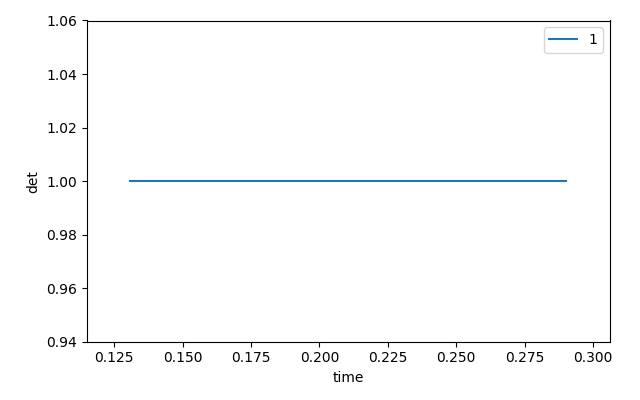

|         1 | 09:18:37.9 |      1.000 |
|         2 | 09:18:38.1 |      1.000 |
|         3 | 09:18:38.1 |      1.000 |
|         4 | 09:18:38.1 |      1.000 |
|         5 | 09:18:38.1 |      1.000 |
+-----------+------------+------------+
generator count ['dda5fba6'] (scan num: 1)





('dda5fba6-989a-4069-9aa3-d40415534e4c',)

In [13]:
RE(plans.count([det], num=5))

Slightly more interesting is a basic scan where we observe a fixed set of points of a motor reading our detector at each point. If you don't have a detector to read you can just pass in an empty list. The following will scan between -5, 5 in 10 steps.

Transient Scan ID: 2     Time: 2018/03/14 09:18:38
Persistent Unique Scan ID: '8f13258c-1c09-41e9-a774-97f3a56a0e1c'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+


<IPython.core.display.Javascript object>


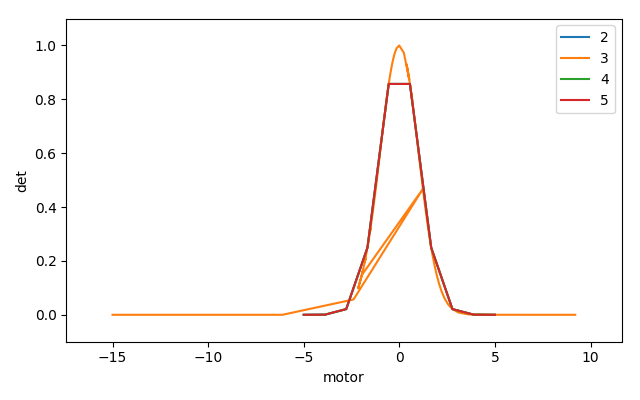

|         1 | 09:18:38.3 |     -5.000 |      0.000 |
|         2 | 09:18:38.4 |     -3.889 |      0.001 |
|         3 | 09:18:38.4 |     -2.778 |      0.021 |
|         4 | 09:18:38.4 |     -1.667 |      0.249 |
|         5 | 09:18:38.4 |     -0.556 |      0.857 |
|         6 | 09:18:38.4 |      0.556 |      0.857 |
|         7 | 09:18:38.5 |      1.667 |      0.249 |
|         8 | 09:18:38.5 |      2.778 |      0.021 |
|         9 | 09:18:38.5 |      3.889 |      0.001 |
|        10 | 09:18:38.5 |      5.000 |      0.000 |
+-----------+------------+------------+------------+
generator scan ['8f13258c'] (scan num: 2)





('8f13258c-1c09-41e9-a774-97f3a56a0e1c',)

In [14]:
plan = plans.scan([det], motor, -5, 5, num=10)
RE(plan)

More complex scans are possible including adaptive scans where areas of interest receive a higher density of measurements

In [15]:
RE(plans.adaptive_scan([det], 'det', motor,
                       start=-15,
                       stop=10,
                       min_step=0.01,
                       max_step=5,
                       target_delta=.05,
                       backstep=True))

Transient Scan ID: 3     Time: 2018/03/14 09:18:38
Persistent Unique Scan ID: '4cde65ae-84b9-47f6-94b7-14d0331e42b4'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 09:18:38.7 |    -15.000 |      0.000 |
|         2 | 09:18:38.7 |    -12.505 |      0.000 |
|         3 | 09:18:38.8 |     -9.509 |      0.000 |
|         4 | 09:18:38.8 |     -6.112 |      0.000 |
|         5 | 09:18:38.8 |     -2.395 |      0.057 |
|         6 | 09:18:38.8 |      1.233 |      0.468 |
|         7 | 09:18:38.8 |     -1.953 |      0.148 |
|         8 | 09:18:38.8 |     -2.154 |      0.098 |
|         9 | 09:18:38.8 |     -1.903 |      0.164 |
|        10 | 09:18:38.8 |     -1.961 |      0.146 |
|        11 | 09:18:38.8 |     -1.767 |      0.210 |
|        12 | 09:18:38.8 |     -1.809 |      0.195 |
|        13 | 09:18:38.8 |     -1.656 |      0.254 |
|        14 |

('4cde65ae-84b9-47f6-94b7-14d0331e42b4',)

### Including the DAQ

What has been ignored in these examples is the inclusion of the DAQ. There are a few simple helper functions that cover basic modes of operations. The simplest behavior is just running the DAQ throughout the whole scan and stopping at the end. This can be accomlished by passing any plan you want to run this way through the `daq_wrapper` and setting the mode to `"on"`

In [16]:
RE(plans.daq_wrapper(plans.scan([det], motor, -5, 5, num=10), mode='on'))

INFO     Daq configured
Transient Scan ID: 4     Time: 2018/03/14 09:18:39
Persistent Unique Scan ID: 'cd9c1873-4519-48d2-bd88-21cd1a7d9c53'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 09:18:39.7 |     -5.000 |      0.000 |
|         2 | 09:18:39.7 |     -3.889 |      0.001 |
|         3 | 09:18:39.7 |     -2.778 |      0.021 |
|         4 | 09:18:39.7 |     -1.667 |      0.249 |
|         5 | 09:18:39.7 |     -0.556 |      0.857 |
|         6 | 09:18:39.8 |      0.556 |      0.857 |
|         7 | 09:18:39.8 |      1.667 |      0.249 |
|         8 | 09:18:39.8 |      2.778 |      0.021 |
|         9 | 09:18:39.8 |      3.889 |      0.001 |
|        10 | 09:18:39.9 |      5.000 |      0.000 |
+-----------+------------+------------+------------+
generator scan ['cd9c1873'] (scan num: 4)





('cd9c1873-4519-48d2-bd88-21cd1a7d9c53',)

More complex behavior is available. For instance, if you want the DAQ to only run at certain points in your scan you can set the mode to `"manual"`. This requries the plan itself to start and stop the DAQ when necessary. The most common mode of operation for this mode is when performing calibration cycles. For this we can utilize the `calib_at_step` stub plan built-in into the `pcdsdaq` module. This function is then placed in the `per_step`

In [17]:
RE(plans.daq_wrapper(plans.scan([det], motor, -5, 5, num=10,
                                 per_step=plans.calib_at_step(events=50)),
                     mode='manual'))

INFO     Daq configured
Transient Scan ID: 5     Time: 2018/03/14 09:18:40
Persistent Unique Scan ID: 'c4218a45-7ce5-4655-b35a-1bd85174e93d'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 09:18:40.1 |     -5.000 |      0.000 |
|         2 | 09:18:40.6 |     -3.889 |      0.001 |
|         3 | 09:18:41.1 |     -2.778 |      0.021 |
|         4 | 09:18:41.7 |     -1.667 |      0.249 |
|         5 | 09:18:42.2 |     -0.556 |      0.857 |
|         6 | 09:18:42.7 |      0.556 |      0.857 |
|         7 | 09:18:43.2 |      1.667 |      0.249 |
|         8 | 09:18:43.7 |      2.778 |      0.021 |
|         9 | 09:18:44.2 |      3.889 |      0.001 |
|        10 | 09:18:44.7 |      5.000 |      0.000 |
+-----------+------------+------------+------------+
generator scan ['c4218a45'] (scan num: 5)





('c4218a45-7ce5-4655-b35a-1bd85174e93d',)